### Analysing our data set with R
Getting frames, grepping all the words, showing most popular of them

In [2]:
get.frame <- function(path) {
  frame <- read.csv(path, sep = ";")
  names(frame) <- c("sentence", "label")
  return(frame)
}

In [3]:
test.frame <- get.frame("./data/test.txt")
train.frame <- get.frame("./data/train.txt")
valid.frame <- get.frame("./data/val.txt")

In [4]:
get.occurences <- function(frame) {
  words <- unlist(strsplit(as.character(frame$sentence), " "))
  occurences <- table(words)
  frame <- data.frame(occurences)
  names(frame) <- c("word", "count")
  return(frame)
}

Now, we have everything prepared to grep top popular words in our dataset. <br>
Let's add up all frames together and get word occurences. <br>
And after that let's draw a pie chart

In [5]:
draw.top.words <- function(frame, top.limit = 20, length.limit = 4) {
  long.words <- frame[nchar(as.character(frame$word)) > length.limit, ]
  sorted.words <- long.words[order(long.words$count, decreasing = TRUE), ]
  top.words <- sorted.words[1:top.limit, ]
  par(bg = "white")
  pie(x = top.words$count, labels = top.words$word)
}

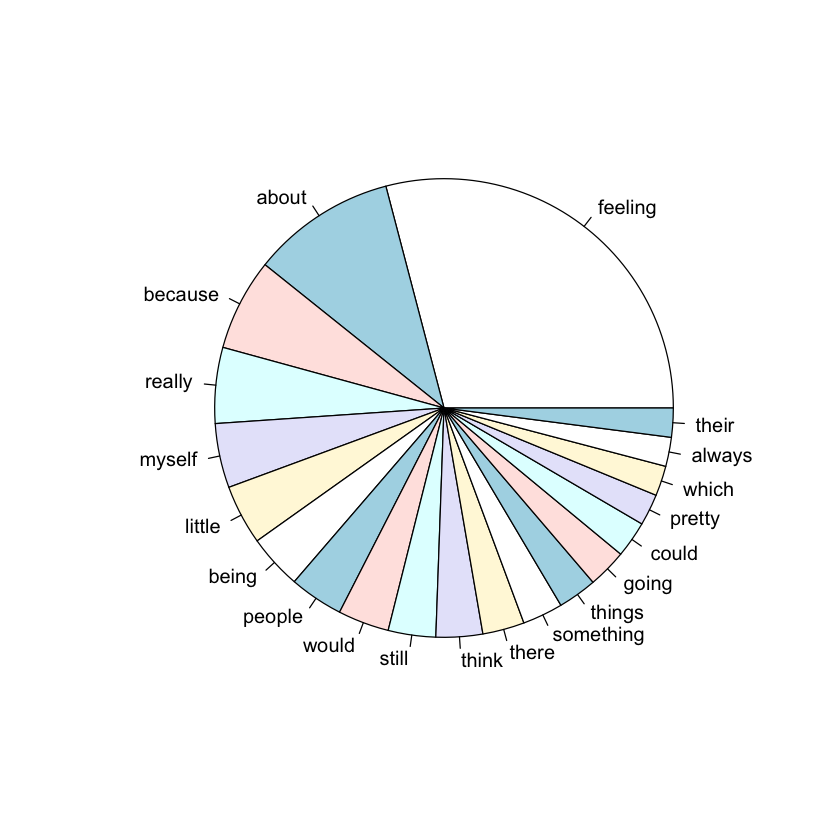

In [28]:
general.frame <- rbind(test.frame, train.frame, valid.frame)
word.table <- get.occurences(general.frame)
draw.top.words(word.table, top.limit = 20, length.limit = 4)

### Vocabulary and tokenizing
Firstly we need to tokenize our sentences <br>
Since the sentences are lowercased and containing only words separated by spaces, <br>
We need:
1. Create a vocabulary (sort our word table and take only top n words)
2. Create a mapping: vocabulary -> unique id
2. Encoding function: splits sentence into words and encodes every word as an id

In [78]:
library(hash)

create.vocabulary <- function(word.map, threshold = 1e4) {
  sorted <- word.map[order(word.map$count, decreasing = TRUE), ]
  top <- sorted[1:threshold, ]
  vocabulary <- hash()

  for (i in 1:threshold) {
    word <- as.character(top$word[i])
    vocabulary[[word]] <- i
  }

  return(vocabulary)
}

In [86]:
vocabulary <- create.vocabulary(word.table)

get.word.id <- function (word) {
  if (has.key(word, vocabulary)) {
    return(vocabulary[[word]])
  }
  return(-1)
}

In [126]:
first.sentence <- as.character(train.frame$sentence[1])
first.sentence.words <- unlist(strsplit(first.sentence, " "))
ids <- sapply(first.sentence.words, get.word.id)
for (i in seq_along(ids)) {
  word <- names(ids)[i]
  id <- ids[i]
  print(paste(word, "->", id))
}

[1] "i -> 1"
[1] "can -> 39"
[1] "go -> 101"
[1] "from -> 59"
[1] "feeling -> 7"
[1] "so -> 14"
[1] "hopeless -> 526"
[1] "to -> 4"
[1] "so -> 14"
[1] "damned -> 3210"
[1] "hopeful -> 550"
[1] "just -> 31"
[1] "from -> 59"
[1] "being -> 61"
[1] "around -> 128"
[1] "someone -> 144"
[1] "who -> 72"
[1] "cares -> 1711"
[1] "and -> 3"
[1] "is -> 21"
[1] "awake -> 1388"


### Building a model
We gonna build our model using Tensorflow for R programming language

In [4]:
library(tensorflow)
library(keras)

model <- keras_model_sequential()
model %>%
  layer_embedding(input_dim = 10000, output_dim = 128) %>%
  layer_simple_rnn(units = 32) %>%
  layer_dense(units = 6, activation = "softmax")

model %>% compile (
  loss = "sparse_categorical_crossentropy",
  optimizer = "adam",
  metrics = c("accuracy")
)

## TODO:
I need to feed the model